In [1]:
import os
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from dotenv import load_dotenv

from EHydro_TreeUnet.trainers import TreeProjectorTrainer
from torchsparse.nn import functional as F

F.set_kmap_mode("hashmap_on_the_fly")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
load_dotenv()

TREE_PROJECTOR_DIR = Path(os.environ.get('TREE_PROJECTOR_DIR', Path.home() / 'tree_projector'))
DATASET_FOLDER = 'MixedDataset'
VERSION_NAME = 'tree_projector_instance_VS-0.2_DA-48_E-3'

VOXEL_SIZE = 0.2
FEAT_KEYS = ['intensity']
CENTROID_SIGMA = 1.0
TRAIN_PCT = 0.9
DATA_AUGMENTATION_COEF = 48
YAW_RANGE = (0.0, 360.0)
TILT_RANGE = (-5.0, 5.0)
SCALE_RANGE = (0.9, 1.1)

TRAINING = True
EPOCHS = 3
START_ON_EPOCH = 0
BATCH_SIZE = 1
SEMANTIC_LOSS_COEF = 1.0
CENTROID_LOSS_COEF = 1.0
INSTANCE_LOSS_COEF = 1.0

RESNET_BLOCKS = [
    (3, 16, 3, 1),
    (3, 32, 3, 2),
    (3, 64, 3, 2),
    (3, 128, 3, 2),
    (1, 128, (1, 1, 3), (1, 1, 2)),
]
LATENT_DIM = 256
INSTANCE_DENSITY = 0.01
CENTROID_THRES = 0.1
DESCRIPTOR_DIM = 32

CHARTS_IGNORE_CLASS = []

In [3]:
def smooth(arr: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return arr

    kernel = np.ones(window, dtype=float)
    if arr.ndim == 1:
        denom = np.convolve(np.ones_like(arr), kernel, mode="same")
        return np.convolve(arr, kernel, mode="same") / denom

    # 2-D: suavizar cada columna por separado
    smoothed = np.empty_like(arr, dtype=float)
    denom = np.convolve(np.ones(arr.shape[0]), kernel, mode="same")
    for c in range(arr.shape[1]):
        smoothed[:, c] = np.convolve(arr[:, c], kernel, mode="same") / denom
    return smoothed
        
def gen_charts(trainer, losses, stats, training: bool, window: int = 1, ignore_class = []):
    keys = stats[0].keys()
    stats = {k: np.array([d[k] for d in stats]) for k in keys}

    loss            = np.asarray(losses)
    print(loss.shape)
    loss_s          = np.clip(smooth(loss[:, 0], window), 0.0, 10.0)
    loss_sem_s      = np.clip(smooth(loss[:, 1], window), 0.0, 10.0)
    loss_centroid_s = np.clip(smooth(loss[:, 2], window), 0.0, 10.0)
    loss_inst_s     = np.clip(smooth(loss[:, 3], window), 0.0, 10.0)
    miou_s          = smooth(stats['miou'], window)
    iou_s           = smooth(np.asarray(stats['iou_per_class']), window)
    prec_macro_s    = smooth(stats['precision_macro'], window)
    prec_s          = smooth(np.asarray(stats['precision_per_class']), window)
    recall_macro_s  = smooth(stats['recall_macro'], window)
    recall_s        = smooth(np.asarray(stats['recall_per_class']), window)
    f1_macro_s      = smooth(stats['f1_macro'], window)
    f1_s            = smooth(np.asarray(stats['f1_per_class']), window)

    # --- Global loss -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(loss_s, label=f"{'Training' if training else 'Inference'} Loss (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Semantic loss ----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(loss_sem_s, label=f"{'Training' if training else 'Inference'} Loss (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Centroid loss ----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(loss_centroid_s, label=f"{'Training' if training else 'Inference'} Loss (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Instance loss ----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(loss_inst_s, label=f"{'Training' if training else 'Inference'} Loss (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
    plt.legend(); plt.grid(True); plt.show()

    # --- mIoU (macro) -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(miou_s, label=f"{'Training' if training else 'Inference'} mIoU (MA{window})")
    plt.xlabel("Step"); plt.ylabel("mIoU")
    plt.title(f"mIoU evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- IoU per class ----------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(iou_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("IoU")
    plt.title(f"IoU evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- Precision (macro) -----------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(prec_macro_s, label=f"{'Training' if training else 'Inference'} precision (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Precision")
    plt.title(f"Precision evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- Precision per class ---------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(prec_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("Precision")
    plt.title(f"Precision evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- Recall (macro) ---------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(recall_macro_s, label=f"{'Training' if training else 'Inference'} recall (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Recall")
    plt.title(f"Recall evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- Recall per class -------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(recall_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("Recall")
    plt.title(f"Recall evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- F1 (macro) -------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(f1_macro_s, label=f"{'Training' if training else 'Inference'} F1 (MA{window})")
    plt.xlabel("Step"); plt.ylabel("F1")
    plt.title(f"F1 evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- F1 per class -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(f1_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("F1")
    plt.title(f"F1 evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    column_names = ['IoU', 'Precision', 'Recall', 'F1']
    row_names = [trainer.dataset.class_names[c] for c in range(trainer.dataset.num_classes) if trainer.dataset.class_names[c] not in ignore_class]
    row_names.append('Mean')

    iou_arr = np.asarray(stats['iou_per_class'])
    prec_arr = np.asarray(stats['precision_per_class'])
    recall_arr = np.asarray(stats['recall_per_class'])
    f1_arr = np.asarray(stats['f1_per_class'])

    data = [
        [iou_arr[:, c].mean(), prec_arr[:, c].mean(), recall_arr[:, c].mean(), f1_arr[:, c].mean()]
    for c in range(trainer.dataset.num_classes) if trainer.dataset.class_names[c] not in ignore_class]

    means = np.array(data).mean(axis=0)
    data.append(list(means))

    df = pd.DataFrame(data, columns=column_names, index=row_names)
    display(df)

Parámetros totales: 26,487,374
Parámetros entrenables: 26,487,374
Resnet generates features at the following scales:
	* (0.2, 0.2, 0.2) meters -> 16 feats.
	* (0.4, 0.4, 0.4) meters -> 32 feats.
	* (0.8, 0.8, 0.8) meters -> 64 feats.
	* (1.6, 1.6, 1.6) meters -> 128 feats.
	* (1.6, 1.6, 3.2) meters -> 128 feats.

Minimum scene size: (4.8, 4.8, 9.6) meters
Total channels in backbone: 368 -> 256 in latent space.

=== Starting epoch 1 ===
Training instance correlation with labels instead of predictions by now...



[Train]: 100%|██████████| 1/1 [00:06<00:00,  6.42s/it, loss=16.8723, mIoU=0.0284, centroid loss=11.5199, mAP=0.0874, centroids found=25 (2) / 26]



✅ Epoch 1 finished.

=== Starting epoch 2 ===


[Train]: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it, loss=16.2689, mIoU=0.0284, centroid loss=11.5199, mAP=0.0000, centroids found=0 (1) / 26]



✅ Epoch 2 finished.

=== Starting epoch 3 ===
Training instance correlation with predictions.



[Train]: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it, loss=16.2689, mIoU=0.0284, centroid loss=11.5199, mAP=0.0000, centroids found=0 (1) / 26]



✅ Epoch 3 finished.
(3, 4)


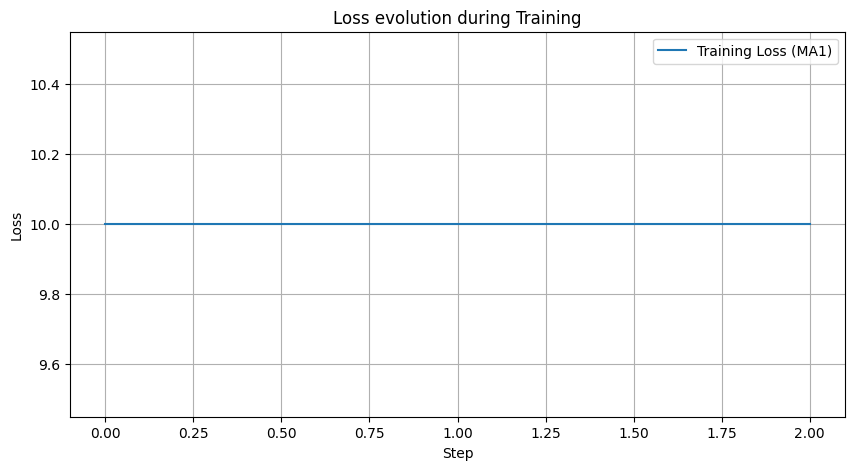

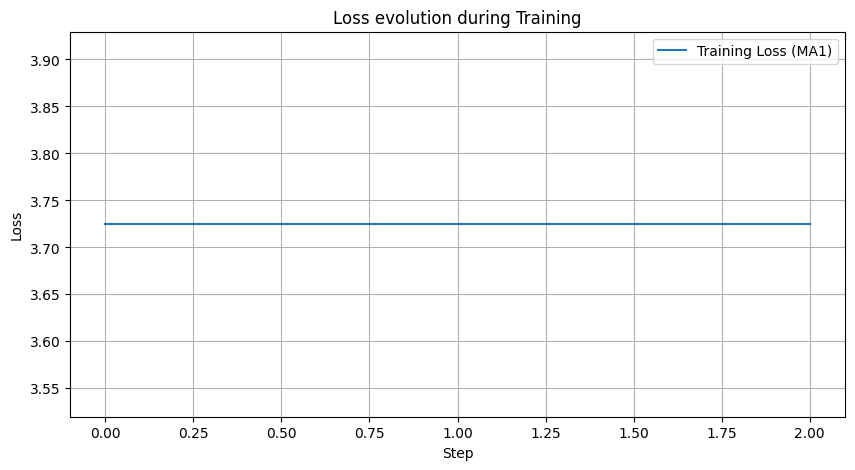

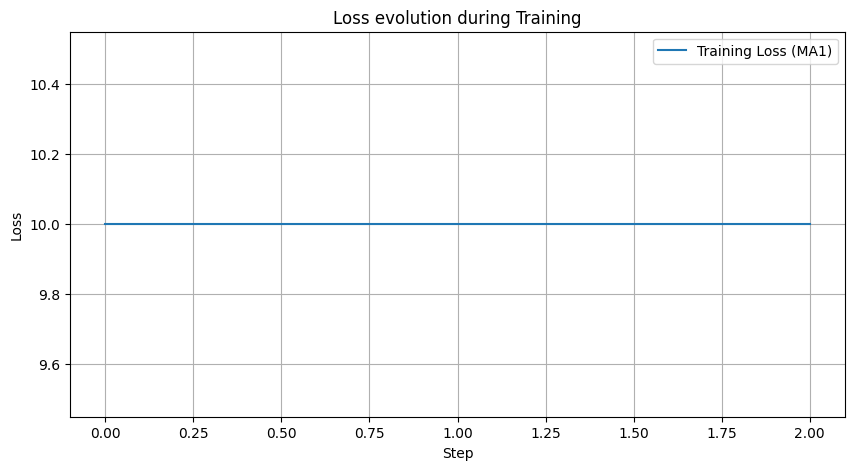

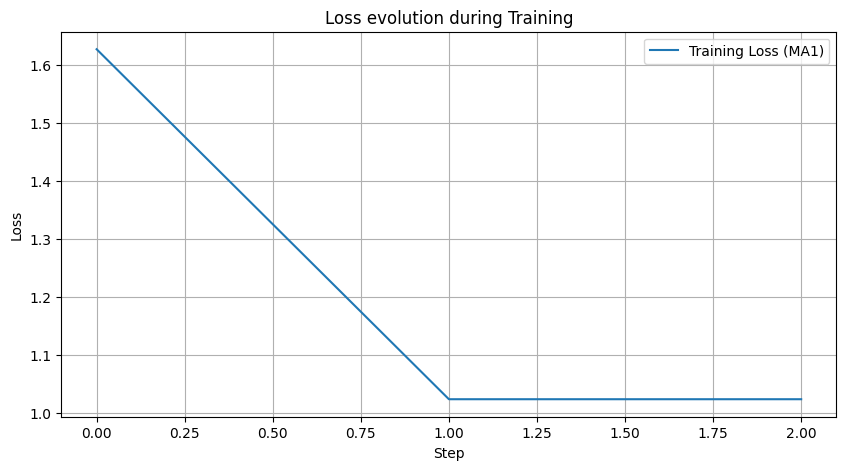

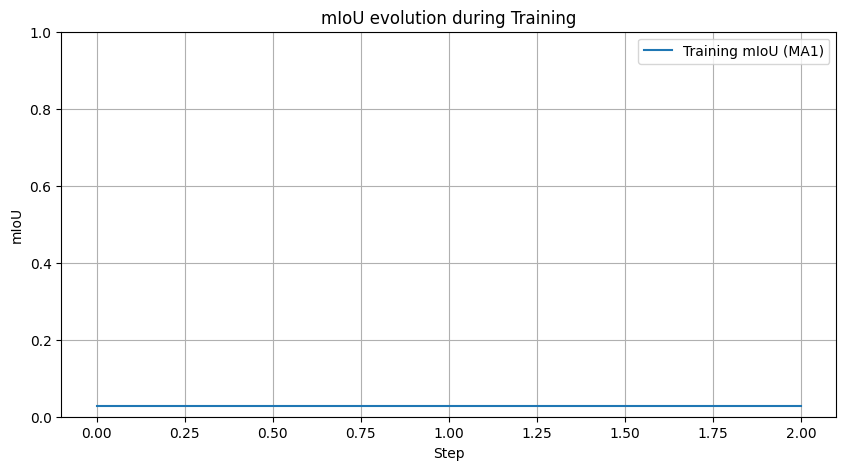

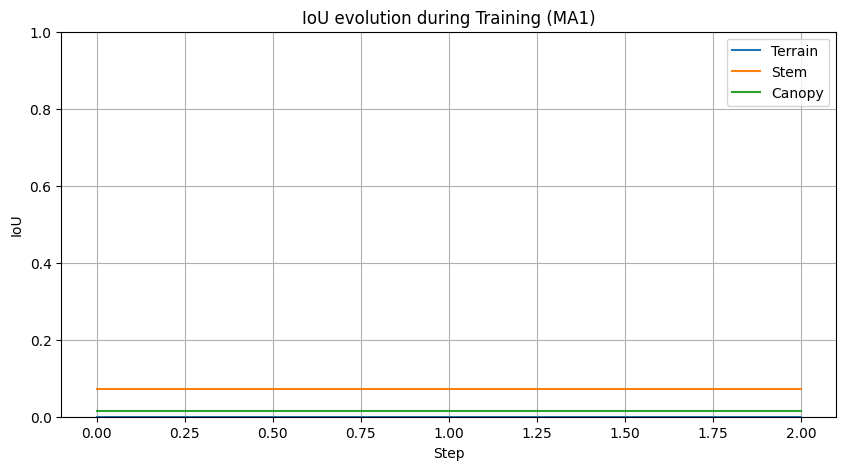

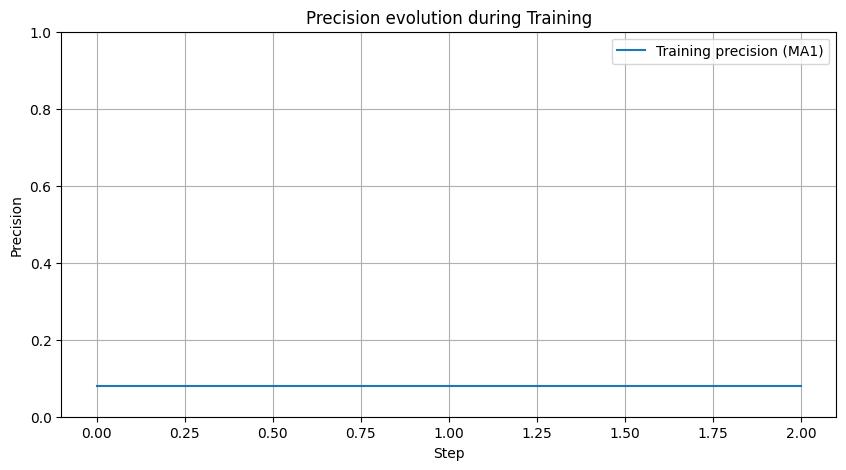

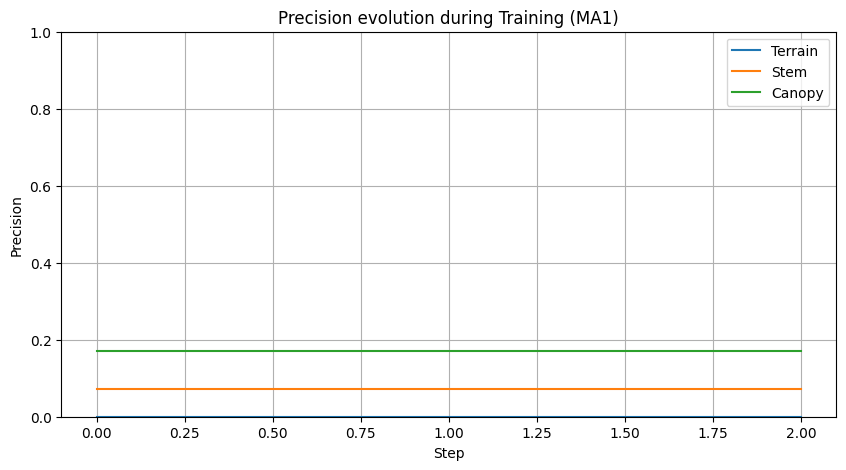

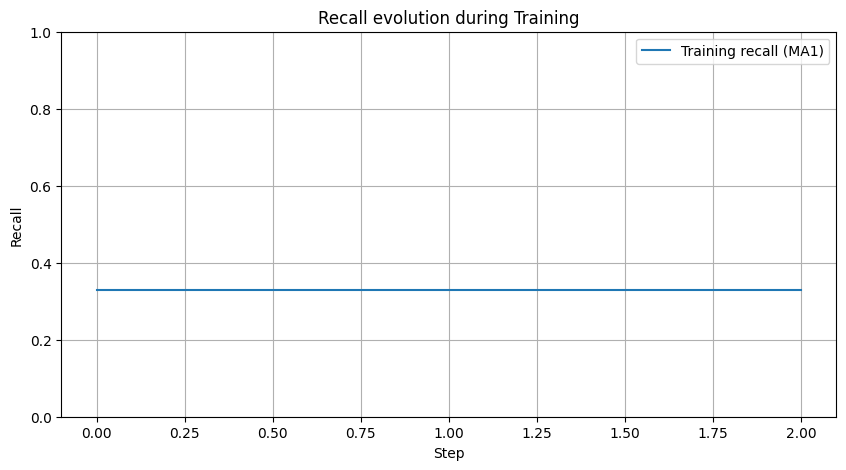

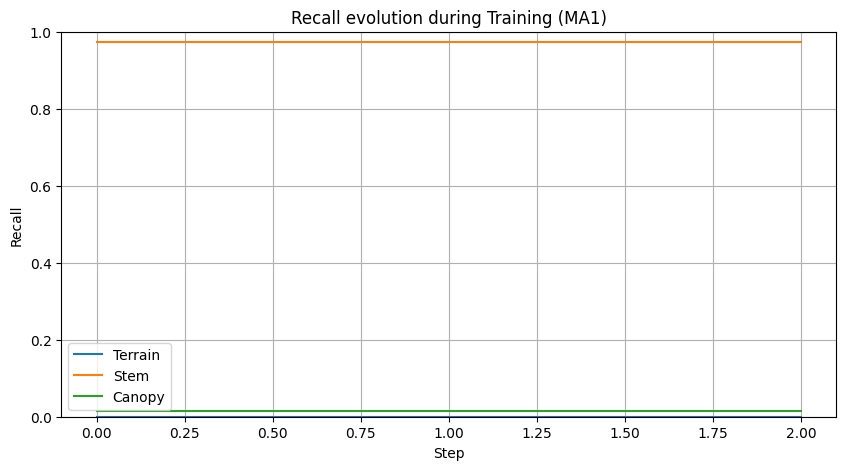

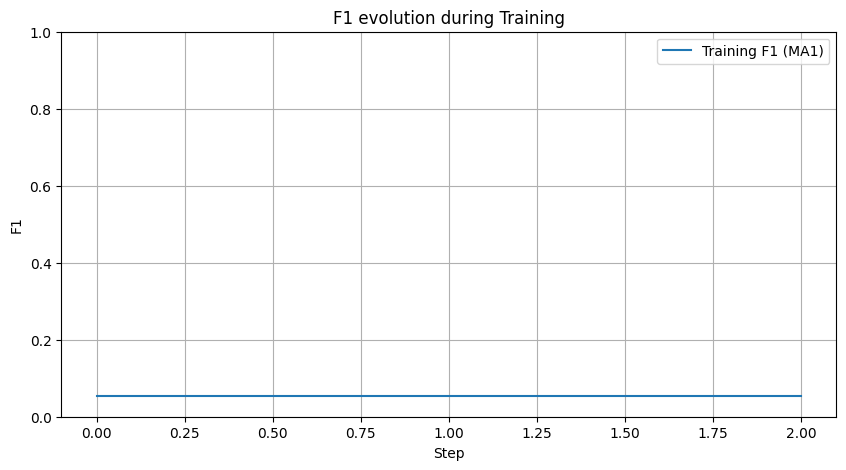

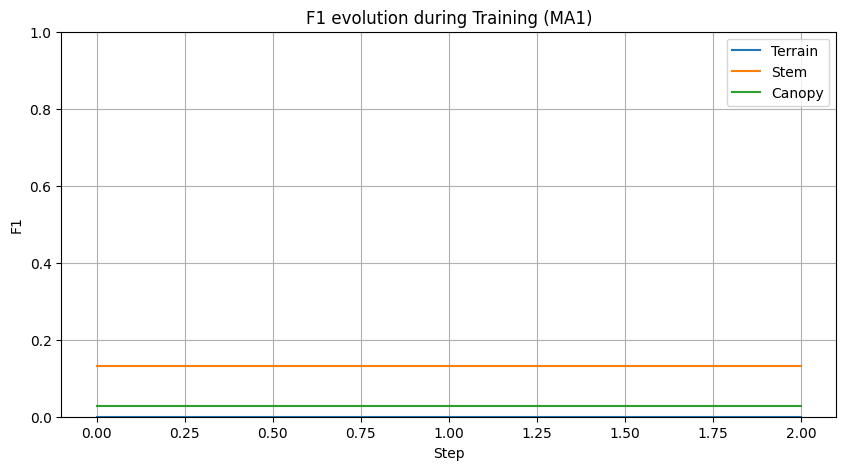

,IoU,Precision,Recall,F1
Terrain,0.000000,0.000000,0.000000,0.000000
Stem,0.071140,0.071279,0.973340,0.132831
Canopy,0.013979,0.171278,0.014993,0.027572
Mean,0.028373,0.080852,0.329444,0.053468


[Inference]: 100%|██████████| 91/91 [01:58<00:00,  1.31s/it, loss=11.2528, mIoU=0.0255, centroid loss=7.4845, mAP=0.0000, centroids found=0 (1) / 18] 

(91, 4)


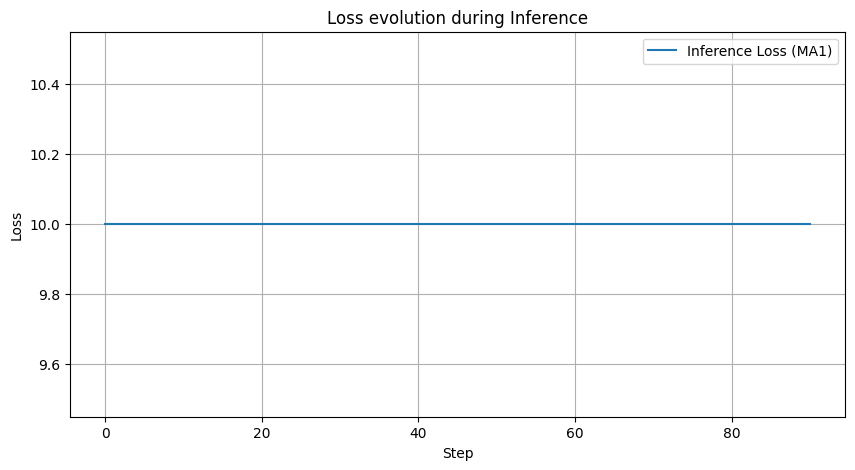

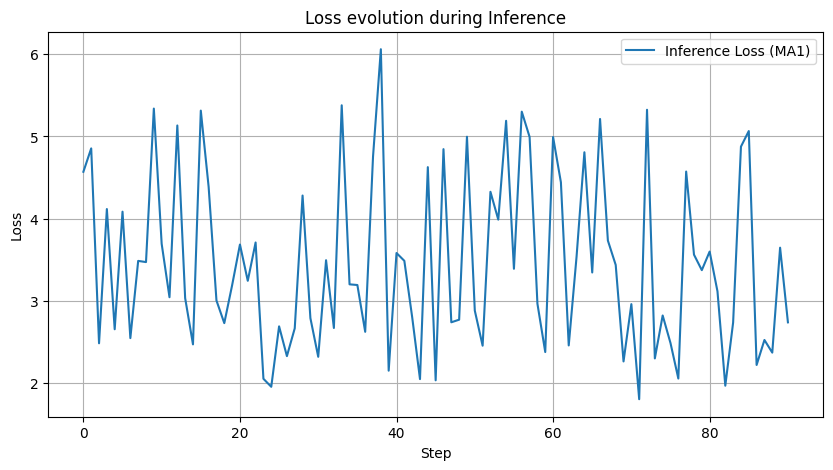

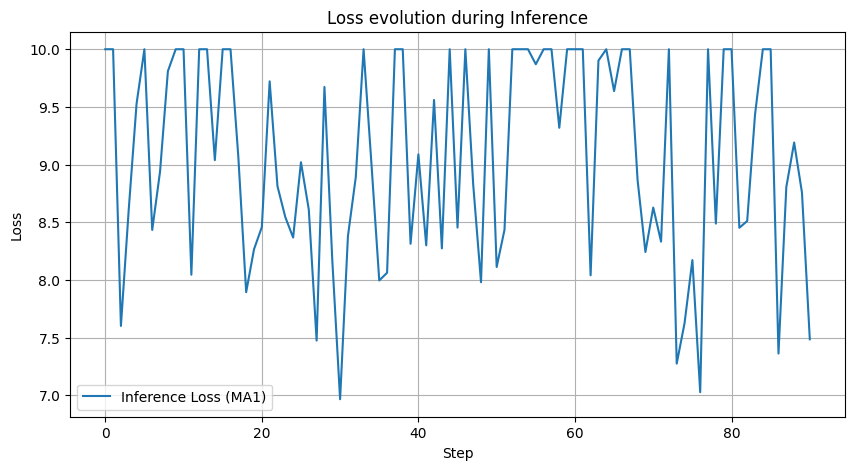

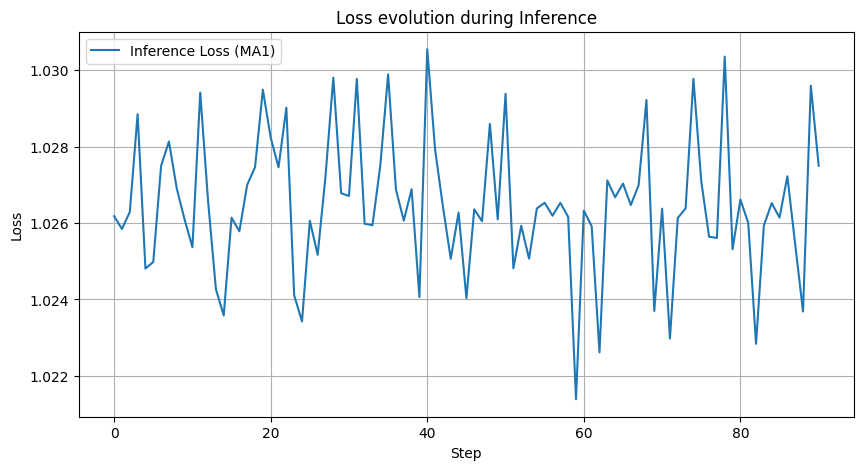

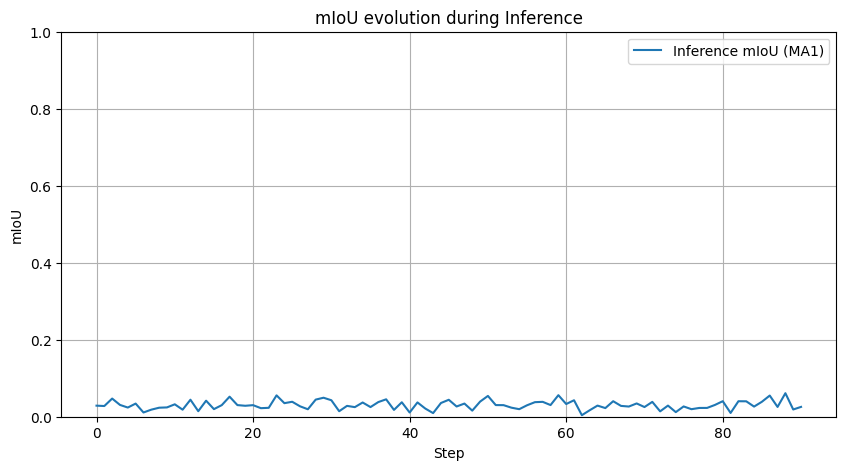

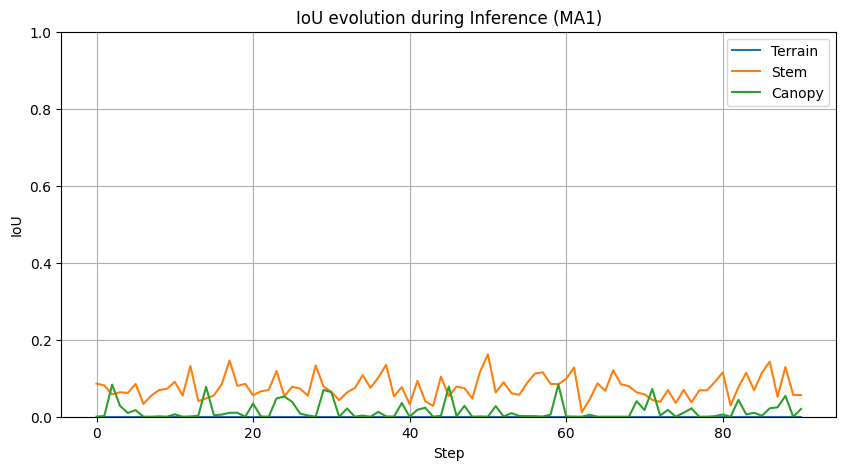

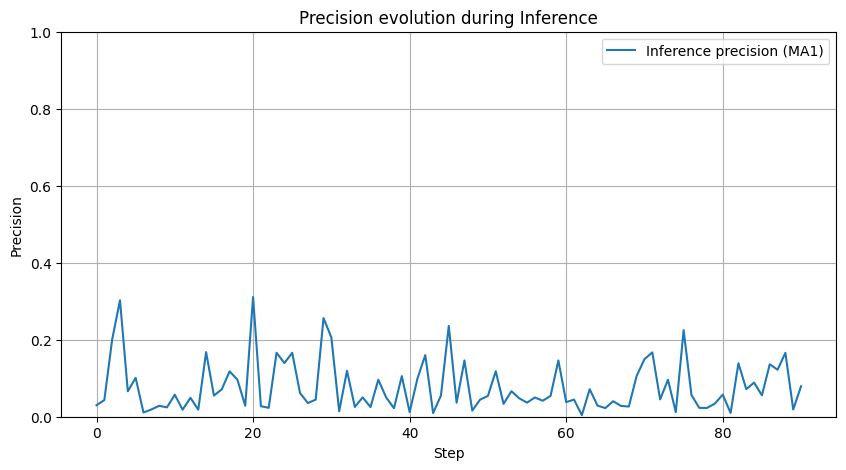

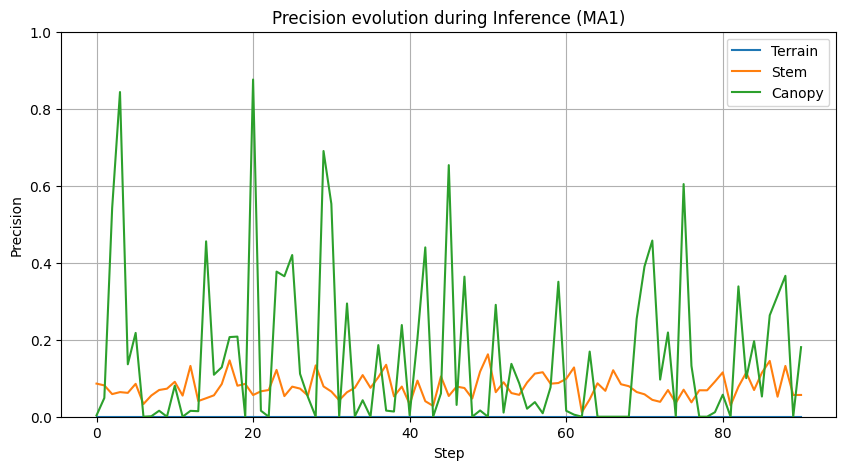

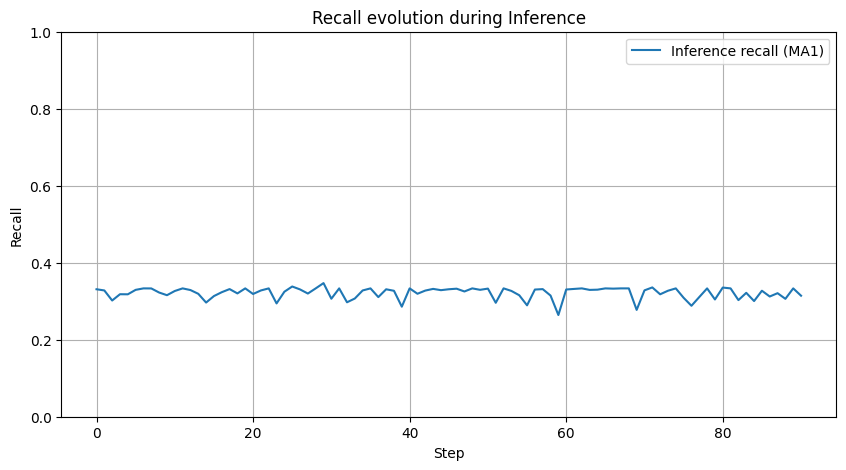

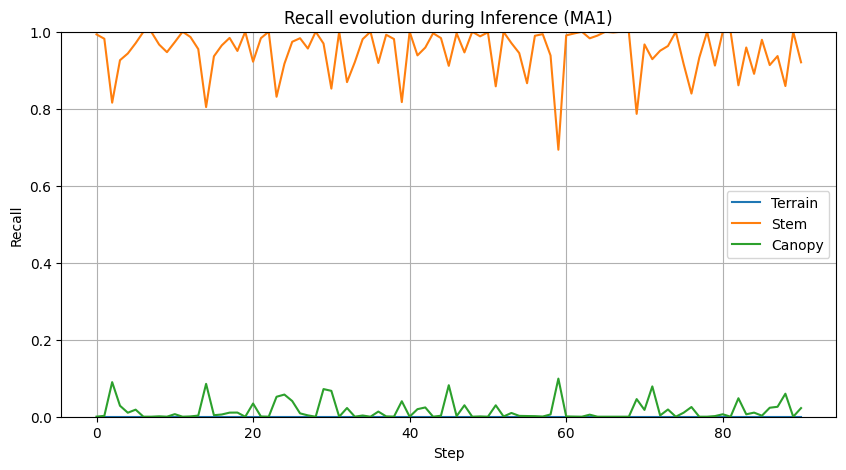

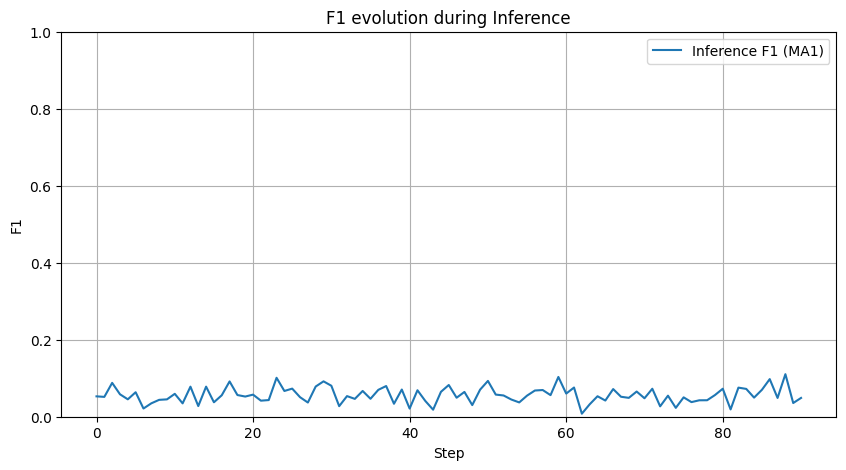

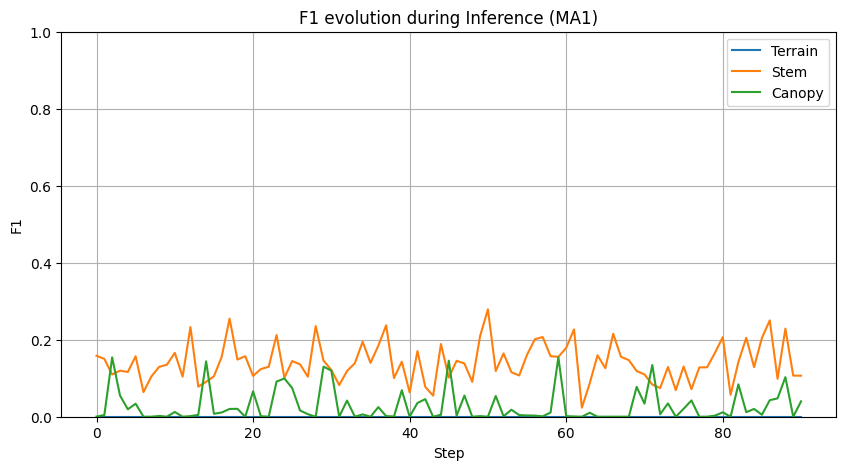

,IoU,Precision,Recall,F1
Terrain,0.000000,0.000000,0.000000,0.000000
Stem,0.076520,0.076874,0.949531,0.140744
Canopy,0.014462,0.157072,0.015598,0.027613
Mean,0.030327,0.077982,0.321710,0.056119


In [4]:
tester = TreeProjectorTrainer(
    tree_projector_dir=TREE_PROJECTOR_DIR,
    dataset_folder=DATASET_FOLDER,
    version_name=VERSION_NAME,

    voxel_size=VOXEL_SIZE,
    feat_keys=FEAT_KEYS,
    centroid_sigma=CENTROID_SIGMA,
    train_pct=TRAIN_PCT,
    data_augmentation_coef=DATA_AUGMENTATION_COEF,

    training=TRAINING,
    epochs=EPOCHS,
    start_on_epoch=START_ON_EPOCH,
    batch_size=BATCH_SIZE,
    semantic_loss_coef=SEMANTIC_LOSS_COEF,
    centroid_loss_coef=CENTROID_LOSS_COEF,
    instance_loss_coef=INSTANCE_LOSS_COEF,

    resnet_blocks=RESNET_BLOCKS,
    latent_dim=LATENT_DIM,
    instance_density=INSTANCE_DENSITY,
    centroid_thres=CENTROID_THRES,
    descriptor_dim=DESCRIPTOR_DIM
)

if TRAINING:
    tester.train()
    stats = tester.stats
    losses = tester.losses
    gen_charts(tester, losses, stats, True, ignore_class=CHARTS_IGNORE_CLASS)

pcd = o3d.geometry.PointCloud()
pcd2 = o3d.geometry.PointCloud()
for voxels, semantic_output, semantic_labels, centroid_score_output, centroid_score_labels, instance_output, instance_labels, centroid_voxels, centroid_confidence_output in tester.eval():
    continue
    batch_idx = voxels[:, 0]
    centroid_batch_idx = centroid_voxels[:, 0]
    voxels = voxels[:, 1:]
    centroid_voxels = centroid_voxels[:, 1:]

    for idx in np.unique(batch_idx):
        mask = batch_idx == idx
        cloud_voxels = voxels[mask]
        cloud_semantic_output = semantic_output[mask]
        cloud_semantic_labels = semantic_labels[mask]
        cloud_centroid_score_output = centroid_score_output[mask]
        cloud_centroid_score_labels = centroid_score_labels[mask]
        cloud_instance_output = instance_output[mask]
        cloud_instance_labels = instance_labels[mask]

        mask = centroid_batch_idx == idx
        cloud_centroid_voxels = centroid_voxels[mask]
        cloud_centroid_confidence_output = centroid_confidence_output[mask]

        pcd.points = o3d.utility.Vector3dVector(cloud_voxels)

        colors = tester.dataset.class_colormap[cloud_semantic_labels] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        colors = tester.dataset.class_colormap[cloud_semantic_output] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        cmap = plt.get_cmap('viridis')

        colors = cmap(cloud_centroid_score_labels[:, 0])[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        colors = cmap(cloud_centroid_score_output[:, 0])[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        spheres = []
        colors = tester.dataset.class_colormap[cloud_semantic_labels] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        for i in range(cloud_centroid_voxels.shape[0]):
            center = cloud_centroid_voxels[i]
            confidence = cloud_centroid_confidence_output[i][0]

            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.5)
            sphere.translate(center)
            color = cmap(confidence)[:3]
            sphere.paint_uniform_color(color)
            spheres.append(sphere)

        o3d.visualization.draw_geometries([pcd] + spheres)

        unique_ids = np.unique(cloud_instance_labels)
        rng = np.random.default_rng(0)
        palette = rng.random((len(unique_ids), 3))

        id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
        colors = np.array([id2color[i] for i in cloud_instance_labels], dtype=np.float64)

        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        unique_ids = np.unique(cloud_instance_output)
        rng = np.random.default_rng(0)
        palette = rng.random((len(unique_ids), 3))

        id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
        colors = np.array([id2color[i] for i in cloud_instance_output], dtype=np.float64)

        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

gen_charts(tester, tester.losses, tester.stats, False, ignore_class=CHARTS_IGNORE_CLASS)
